# Shot detection 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline
import cv2
import sys
import skvideo.io
from skvideo.measure import scenedet
import json
from scipy.signal import argrelextrema
import urllib
from urlparse import urlparse

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import time as t
import math
import seaborn as sns

In [3]:
import sys
sys.path.append('lmtd')
from lmtd9 import LMTD
from lmtd9 import database as db

In [4]:
# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display
import glob
import os

#import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn import preprocessing
#from keras.utils.np_utils import to_categorical

In [19]:
from ffmpeg_load_audio import ffmpeg_load_audio

In [5]:
lmtd = LMTD()

In [6]:
def createHistograms(img):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue, sat, ilum = hsv_image[:,:,0], hsv_image[:,:,1], hsv_image[:,:,2]    
    hist_hue, bin_edges_hue = np.histogram(np.ndarray.flatten(hue), bins=8)
    hist_sat, bin_edges_sat = np.histogram(np.ndarray.flatten(sat), bins=4)
    hist_ilum, bin_edges_ilum = np.histogram(np.ndarray.flatten(ilum), bins=4)
    return np.hstack((hist_hue, hist_sat, hist_ilum))

In [7]:
def histogram_intersection(previousHist, currentHist):
    s_i = 0
    #for each bin 
    #print(currentHist.shape[0])
    for j in range(currentHist.shape[0]):
        min_bin_s_i = min(currentHist[j],previousHist[j])
        #print('minimum from bin {}: {}'.format(j,min_bin_s_i))
        min_sum_prev = sum(previousHist)
        min_sum_cur = sum(currentHist)
        min_both = min(min_sum_prev, min_sum_cur) #normalize (maximum can be 1)
        s_i+= (min_bin_s_i/float(min_both)) 
    return s_i

In [8]:
def gradE(sNext, sCurrent):
    return sNext-sCurrent

def gradW(sPrevious, sCurrent):
    return sPrevious-sCurrent

def gaussianKernel(x, k=0.1):
    return np.exp(-(x/k)**2)

def smoothed_s(s_i_previous, s_i, s_i_next, lamb=0.1, k=0.1):
    gEi = gradE(s_i_next, s_i)
    gWi = gradW(s_i_previous, s_i)
    CEt = gaussianKernel(np.absolute(gEi))
    CWt = gaussianKernel(np.absolute(gWi))
    stnext_i = s_i + lamb*(CEt*gEi + CWt * gWi)
    return stnext_i

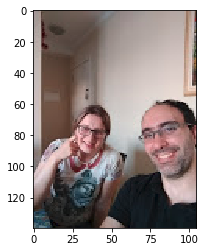

In [9]:
target_image = 'images/paulo_meire.png'
img = cv2.imread(target_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

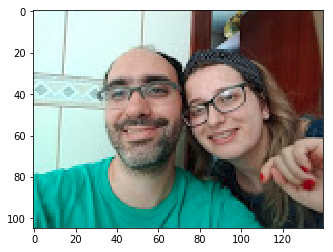

In [10]:
target_image2 = 'images/paulo_meire2.png'
img2 = cv2.imread(target_image2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

[10381   239    31    90  2115   264   102  1478  9078  5133   410    79
  2509  4328  4068  3795]
[6808  512  309 5513 1305   89   26  138 6811 3513  966 3410 1813 3783 4262
 4842]
0.748253968254


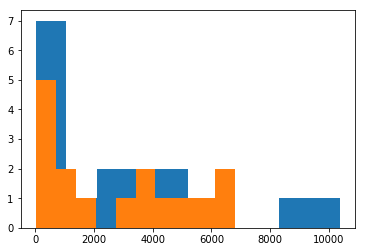

In [11]:
hist1 = createHistograms(img)
plt.hist(hist1)
print(hist1)
hist2 = createHistograms(img2)
plt.hist(hist2)
print(hist2)
print(histogram_intersection(hist1, hist2))

# Color variance

In [12]:
def color_variance(videodata, smooth_scene_cuts):
    Ls = []
    Us = []
    Vs = []
    for frame in smooth_scene_cuts:
        luv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2Luv)
        L, u, v = luv_image[:,:,0], luv_image[:,:,1], luv_image[:,:,2]
        Ls.append(L)
        Us.append(u)
        Vs.append(v)        
    Luv = np.stack((np.array(Ls).flatten(), np.array(Us).flatten(), np.array(Vs).flatten()), axis=0)
    pCov = np.cov(Luv)
    print('covLuv:', pCov)
    print('varL:',np.var(np.array(Ls)))
    print('varU:',np.var(np.array(Us)))
    print('varV:',np.var(np.array(Vs)))
    totalColorVariance = np.linalg.det(pCov)
    print('totalColorVariance:', totalColorVariance)
    return totalColorVariance

# Lighting Key

In [13]:
trailer_ids = lmtd.train_ids
comedy_id = None
horror_id = None
action_id = None

for _id in trailer_ids:
    # Returns a dictionary in which keys are the queried trailer_ids
    movie_data = lmtd.get_data_by_trailer_ids(_id)
    #print(movie_data)
    for metadata in movie_data.keys():
        print('trailer id : ', metadata)
        print('title db : ', movie_data[metadata]['Title'])
        print('genres db : ', movie_data[metadata]['Genre'])
        print('labels       : ', lmtd.train_labels[int(metadata)])
        print('re-converted : ', lmtd.binary_label_to_genre(lmtd.train_labels[int(metadata)])[0])
        if comedy_id is not None and horror_id is not None and action_id is not None:
            break  
        elif ('Comedy' in movie_data[metadata]['Genre']):
            comedy_id = _id
        elif ('Horror' in movie_data[metadata]['Genre']):    
            horror_id = _id            
        elif ('Action' in movie_data[metadata]['Genre']):    
            action_id = _id 
print('Comedy:',comedy_id)
print('Horror:',horror_id)
print('Action:',action_id)

('trailer id : ', '000002')
('title db : ', "'71")
('genres db : ', 'Action, Drama, Thriller')
('labels       : ', array([0, 0, 1, 0, 1, 0, 1, 0, 0]))
('re-converted : ', array(['isComedy', 'isDrama', 'isRomance'],
      dtype='|S11'))
('trailer id : ', '000003')
('title db : ', '+1')
('genres db : ', 'SciFi, Thriller')
('labels       : ', array([0, 0, 0, 1, 1, 0, 0, 0, 1]))
('re-converted : ', array(['isCrime', 'isDrama', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('

('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : 

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db

('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('gen

('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db

('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels   

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db

('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genr

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels   

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : 

('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000004')
('title db : ', '10 Years')
('genres db : ', 'Comedy, Drama, Romance')
('labels       : ', array([1, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAction', 'isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genres db : ', 'Crime, Drama, Thriller')
('labels       : ', array([0, 0, 0, 0, 0, 1, 0, 0, 1]))
('re-converted : ', array(['isHorror', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000005')
('title db : ', '10 to Midnight')
('genr

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db

('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array([0, 0, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isDrama'],
      dtype='|S11'))
('trailer id : ', '000007')
('title db : ', '11-11-11')
('genres db : ', 'Horror, Mystery, Thriller')
('labels       : ', array(

('trailer id : ', '000006')
('title db : ', '10,000 BC')
('genres db : ', 'Action, Adventure, Drama')
('labels       : ', array([0, 1, 0, 0, 1, 0, 0, 0, 0]))
('re-converted : ', array(['isAdventure', 'isDrama'],
      dtype='|S11'))
('trailer id : ', '000003')
('title db : ', '+1')
('genres db : ', 'SciFi, Thriller')
('labels       : ', array([0, 0, 0, 1, 1, 0, 0, 0, 1]))
('re-converted : ', array(['isCrime', 'isDrama', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000003')
('title db : ', '+1')
('genres db : ', 'SciFi, Thriller')
('labels       : ', array([0, 0, 0, 1, 1, 0, 0, 0, 1]))
('re-converted : ', array(['isCrime', 'isDrama', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000003')
('title db : ', '+1')
('genres db : ', 'SciFi, Thriller')
('labels       : ', array([0, 0, 0, 1, 1, 0, 0, 0, 1]))
('re-converted : ', array(['isCrime', 'isDrama', 'isThriller'],
      dtype='|S11'))
('trailer id : ', '000003')
('title db : ', '+1')
('genres db : ', 'SciFi, Thriller')


In [14]:
def lighting_key(videodata, smooth_scene_cuts):    
    hsv_images = []
    for frame in smooth_scene_cuts:
        hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        hsv_images.append(hsv_image)        
    meanHsv = np.mean(hsv_images)
    stdHsv = np.std(hsv_images)
    lightingkey = meanHsv * stdHsv
    print(lightingkey)
    return lightingkey

# Motion Content

In [15]:
def motion_content(videodata, smooth_scene_cuts, w=3):    
    frameOld = smooth_scene_cuts[0]     
    count_active_pixels = 0
    count_all_pixels = 0
    for currentFrame in smooth_scene_cuts:
        Hx = cv2.Sobel(currentFrame,cv2.CV_64F,1,0,ksize=w)
        #print('Hx:',Hx)
        Ht = currentFrame - frameOld  #temporal derivative
        #print('Ht:',Ht)
        Hx2 = Hx * Hx
        #print('Hx2:',Hx2)
        Ht2 = Ht * Ht
        #print('Ht2:',Ht2)
        HxHt = Hx * Ht
        #print('HxHt:',HxHt)
        Jxx = sum(Hx2)
        #print('Jxx:',Jxx)
        Jxt = sum(HxHt)
        #print('Jxt:',Jxt)
        Jtt = sum(Ht2)
        #print('Jtt:',Jtt)
        #print(2*Jxt/(Jxx-Jxt))
        theta = (1/2.0)*np.degrees(np.arctan(2*Jxt/(Jxx-Jxt)))
        count_all_pixels+= theta.size  
        #print(count_all_pixels)
        aux = theta[~np.isnan(theta)]
        aux = aux.flatten()
        #print(aux)
        count_active_pixels += aux[(0.0 < aux) | (aux < 10.0)].size
        #print(count_active_pixels)
        frameOld = currentFrame        
    return count_active_pixels/float(count_all_pixels)

In [16]:
comedy_filename = 'trailers/videos/'+comedy_id+'.mp4'
horror_filename = 'trailers/videos/'+horror_id+'.mp4'
action_filename = 'trailers/videos/'+action_id+'.mp4'

In [18]:
comedy_videometadata = skvideo.io.ffprobe(comedy_filename)
print(comedy_videometadata.keys())
print(json.dumps(comedy_videometadata["video"], indent=4))
print(json.dumps(comedy_videometadata["audio"], indent=4))

[u'audio', u'video']
{
    "@index": "0", 
    "@codec_name": "h264", 
    "@codec_long_name": "H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10", 
    "@profile": "Constrained Baseline", 
    "@codec_type": "video", 
    "@codec_time_base": "1001/48000", 
    "@codec_tag_string": "avc1", 
    "@codec_tag": "0x31637661", 
    "@width": "640", 
    "@height": "360", 
    "@coded_width": "640", 
    "@coded_height": "360", 
    "@has_b_frames": "0", 
    "@sample_aspect_ratio": "1:1", 
    "@display_aspect_ratio": "16:9", 
    "@pix_fmt": "yuv420p", 
    "@level": "30", 
    "@chroma_location": "left", 
    "@refs": "1", 
    "@is_avc": "true", 
    "@nal_length_size": "4", 
    "@r_frame_rate": "24000/1001", 
    "@avg_frame_rate": "24000/1001", 
    "@time_base": "1/24000", 
    "@start_pts": "0", 
    "@start_time": "0.000000", 
    "@duration_ts": "3471468", 
    "@duration": "144.644500", 
    "@bit_rate": "403615", 
    "@bits_per_raw_sample": "8", 
    "@nb_frames": "3468", 
    "disposi

In [ ]:
comedy_videodata = skvideo.io.vread(comedy_filename)
print(comedy_videodata.shape)
T, M, N, C = comedy_videodata.shape

print("Number of frames: %d" % (T,))
print("Number of rows: %d" % (M,))
print("Number of cols: %d" % (N,))
print("Number of channels: %d" % (C,))

frame_rate = comedy_videometadata['video']['@avg_frame_rate']
num_frames = np.int(comedy_videodata.shape[0])
width = np.int(comedy_videometadata['video']['@width'])
height = np.int(comedy_videometadata['video']['@height'])

In [ ]:
# using the "luminance" algorithm
comedy_scene_lum_idx = skvideo.measure.scenedet(comedy_videodata, method='histogram', parameter1=1.0)
comedy_scenecuts = comedy_videodata[comedy_scene_lum_idx]

In [ ]:
print(len(comedy_scenecuts))

In [17]:
def shot_detection(movie_filename):
    videodata = skvideo.io.vread(movie_filename)
    T, M, N, C = videodata.shape
    #videometadata = skvideo.io.ffprobe(movie_filename)
    #frame_rate = videometadata['video']['@avg_frame_rate']
    #num_frames = np.int(videodata.shape[0])
    #width = np.int(videometadata['video']['@width'])
    #height = np.int(videometadata['video']['@height'])
    numFrames, height, width, channels = videodata.shape
    smooth_list = []
    for t in range(2, numFrames-1):
        beforePrevHist = createHistograms(videodata[t-2])
        prevHist = createHistograms(videodata[t-1])
        currHist = createHistograms(videodata[t])
        nextHist = createHistograms(videodata[t+1])
        s_i_prev = histogram_intersection(beforePrevHist,prevHist)
        s_i_cur = histogram_intersection(prevHist,currHist)
        s_i_next = histogram_intersection(currHist,nextHist)  
        s_smooth = smoothed_s(s_i_prev, s_i_cur, s_i_next)
        smooth_list.append(s_smooth)    
    #if first derivative very near 0 (critical point) and second derivative > 0 (local minima)    
    local_minima_index = argrelextrema(np.array(smooth_list), np.less)
    print(local_minima_index)
    #intersects with normal histogram method ()
    threshold_index = [i for i,v in enumerate(smooth_list) if v < 0.7]
    cut_scene_index = sorted(list(set(local_minima_index[0]).intersection(threshold_index)))  
    print('Shots detected:', len(cut_scene_index))
    print('Index cut scenes:', cut_scene_index)
    #plt.ylabel('Shot Detection')
    #plt.xlabel('Frames')
    #plt.show()   
    smooth_scene_cuts = videodata[cut_scene_index]
    return videodata, smooth_scene_cuts

def average_shot_length(videodata, smooth_scene_cuts):
    num_frames = np.int(videodata.shape[0])
    return num_frames/float(len(smooth_scene_cuts))

## Traditional Histogram Cut

In [ ]:
for frame in comedy_scenecuts:
    imgplot = plt.imshow(frame)
    plt.show()

## Smoothed Histogram Cut

In [ ]:
comedy_videodata, comedy_smooth_scene_cuts = shot_detection(comedy_filename)
for frame in comedy_smooth_scene_cuts:
    imgplot = plt.imshow(frame)
    plt.show()

In [ ]:
horror_videodata, horror_smooth_scene_cuts = shot_detection(horror_filename)
for frame in horror_smooth_scene_cuts:
    imgplot = plt.imshow(frame)
    plt.show()

In [ ]:
action_videodata, action_smooth_scene_cuts = shot_detection(action_filename)
for frame in action_smooth_scene_cuts:
    imgplot = plt.imshow(frame)
    plt.show()

## Average Shot Length 

In [ ]:
print('Comedy Average shot length:', average_shot_length(comedy_videodata, comedy_smooth_scene_cuts))
print('Horror Average shot length:', average_shot_length(horror_videodata, horror_smooth_scene_cuts))

## Color Variance

In [ ]:
print('Comedy Color Variance:', color_variance(comedy_videodata, comedy_smooth_scene_cuts))
print('Horror Color Variance:', color_variance(horror_videodata, horror_smooth_scene_cuts))

# Lighting Key

### High value - comedy
### Low value - horror

In [ ]:
print('Comedy Lighting Key:', lighting_key(comedy_videodata, comedy_smooth_scene_cuts))
print('Horror Lighting Key:', lighting_key(horror_videodata, horror_smooth_scene_cuts))

In [ ]:
print('Comedy Motion Content:', motion_content(comedy_videodata, comedy_smooth_scene_cuts))

In [ ]:
print('Horror Motion Content:', motion_content(horror_videodata, horror_smooth_scene_cuts))

In [ ]:
print('Action Motion Content:', motion_content(action_videodata, action_smooth_scene_cuts))

# Audio

In [31]:
def extract_audio_features(audio_path):    
    y, sample_rate = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y, sr=sample_rate, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo_bpm, beats = librosa.beat.beat_track(y=y_percussive, sr=sample_rate)
    stft = np.abs(librosa.stft(y))
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sample_rate)    
    spec_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sample_rate)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
    flatness = librosa.feature.spectral_flatness(y=y)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sample_rate)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    mfcc        = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=40)
    mfccs = np.mean(mfcc.T,axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y_harmonic,sr=sample_rate).T,axis=0)
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sample_rate, hop_length=hop_length)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sample_rate, hop_length=hop_length)
    # Compute global onset autocorrelation
    ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    ac_global = librosa.util.normalize(ac_global)
    return mfccs, chroma_stft, mel,contrast,tonnetz, tempo_bpm, spectral_centroid, spec_bandwith, contrast, flatness, rolloff, zero_crossing_rate, oenv, tempogram, ac_global

In [32]:
extract_audio_features(comedy_filename)

(array([ -1.86603925e+02,   9.58116460e+01,  -9.06310384e+00,
          2.15843037e+01,  -5.50567434e+00,   1.05238956e+01,
         -1.05788906e+01,   3.09651326e+00,  -6.51246162e+00,
          1.56538208e+00,  -5.50607944e+00,   1.84992921e+00,
         -6.05023149e+00,   1.92576207e-01,  -4.89043403e+00,
         -1.15566088e-01,  -6.17648784e+00,  -1.43627200e+00,
         -5.08428480e+00,   5.59225333e-01,  -4.36167223e+00,
         -8.64639446e-01,  -5.64586487e+00,  -1.59917197e+00,
         -4.62486452e+00,  -5.75972797e-01,  -3.64921519e+00,
         -1.51514151e+00,  -2.99638762e+00,   1.97679488e-01,
         -3.19182790e+00,  -8.61906805e-01,  -5.33026278e+00,
         -1.04806440e+00,  -4.13102462e+00,   2.89087377e-01,
         -2.25111335e+00,   8.02230058e-01,  -2.92175646e+00,
         -1.36962779e+00]),
 array([ 0.59125514,  0.64405952,  0.5787569 ,  0.61097532,  0.56783348,
         0.61907736,  0.66296838,  0.58608476,  0.61800276,  0.57505096,
         0.63554758,